In [13]:
import os
import pandas as pd
import plotting
import importlib
importlib.reload(plotting)
import numpy as np
import matplotlib.pyplot as plt 


In [14]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

data_features = pd.read_csv("data/features.csv")

ylabel_name = 'marions_ylabels'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
labeled_num_features = plotting.extract_numerical_features(labeled_data)
print(labeled_num_features.columns)

Index(['overall_slope', 'max_depth', 'max_resistance', 'num_peaks',
       'largest_force_drop', 'largest_force_drop_dep',
       'largest_force_drop_res', 'curve_shape', 'first_quarter_slope',
       'second_quarter_slope', 'third_quarter_slope', 'fourth_quarter_slope',
       'quartile_1', 'quartile_2', 'quartile_3', 'skew', 'kurtosis',
       'k_overall', 'k2cm', 'rsquared', 'word2cm', 'Fpeak', 'dpeak'],
      dtype='object')


# F-Score (Fisher Score)
Compares how much a feature varies between different classes versus how much it varies within the same class

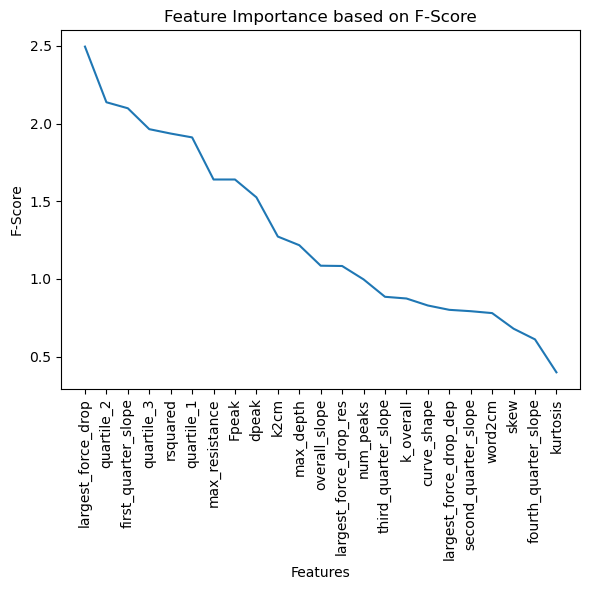

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

X = labeled_num_features.to_numpy() # numerical features
y = labeled_data[f'{ylabel_name}_nums'].to_numpy() # labels
selector = SelectKBest(score_func=f_classif)
selector.fit(X, y)
scores = selector.scores_

# display results
feature_scores = pd.DataFrame({'Feature': labeled_num_features.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

Fig = plt.figure(figsize=(6, 6))
plt.plot(feature_scores['Feature'], feature_scores['Score'])
plt.xlabel('Features')
plt.ylabel('F-Score')  
plt.title('Feature Importance based on F-Score')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

# Create a list of features sorted based on F-Score & no two features having corr > corr_thresh

In [16]:
corr = labeled_num_features.corr()

corr_thresh = 0.7
optimal_features = []
add_feature_flag = 1
for feature in feature_scores['Feature']:
    above_thresh_mask = corr[feature].copy().abs() > corr_thresh
    if above_thresh_mask.sum():
        high_corr_features = corr[above_thresh_mask].index.tolist()

        for high_corr_feature in high_corr_features: 
            if high_corr_feature in optimal_features:
                add_feature_flag = 0

        if add_feature_flag:
            optimal_features.append(feature)
    add_feature_flag = 1

print(optimal_features)

['largest_force_drop', 'quartile_2', 'max_resistance', 'k2cm', 'overall_slope', 'num_peaks', 'curve_shape', 'largest_force_drop_dep', 'word2cm', 'kurtosis']
